# Capstone Project 2: Unsupervised learning - PCA and clustering

This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

# Analysing the data

- Required libraries are imported
- The data set is read using pandas and printed on the screen

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("UsArrests.csv")
data.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## Statistics 

The statistical properties of the columns are summarised as follow:

In [2]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = data.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


## Missing data 

Now we need to check for any missing data using the isnull() function

In [3]:
# Count missing values
missing = data.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


Since there is no missing data, no imputation is needed

## Data types 

It can be useful to check which data types each variables are, and in this case we are working mostly with continuous variables.

In [4]:
# Examine types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


##  Visualisation of observations

Now we will plot histograms using Pandas's .hist() function to visualise the distribution of the observations for each feature:

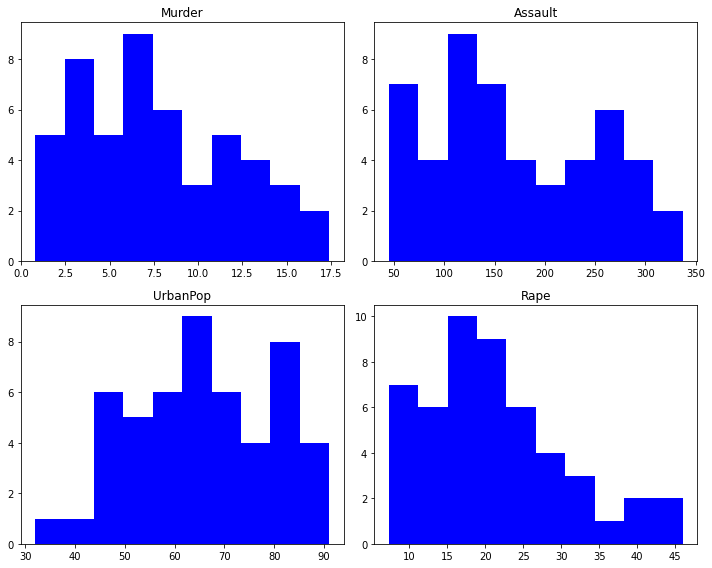

In [5]:
# Plot histograms
histograms = data.hist(color='blue', grid=False, figsize=(10, 8)) 
plt.tight_layout()
plt.show()

## Tabulate results 

The information is tabulated into a single dataframe as shown below:

In [6]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary

,missing,mean,std,min,max
City,0,NaN,NaN,NaN,NaN
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


Looking at the table, 'Assault' has the highest value compared to the other variables. This could be true due to the fact that morally it is more difficult to murder or rape other people.  

## Correlation Analysis

By using Seaborn's function we can plot a correlation heatmap to compute correlations between the different columns.

In [7]:
cities = data.index
corr_data = data.drop(["City"],axis=1).corr()
labels =corr_data.columns

correlations = corr_data.corr()

<AxesSubplot:>

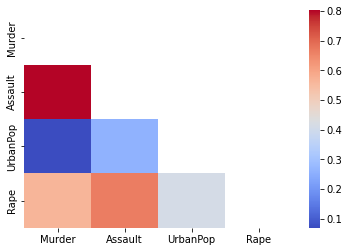

In [8]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_data.shape)).astype(np.bool)
sns.heatmap(corr_data, mask=mask_ut, cmap="coolwarm")

Examining the heatmap, variables which are positively correlated are red while negatively correlated variables are blue.

As expected urban population has a strong negative correlation to murder, as depicted in dark blue. Urban population has a lower negative correlation to assault, as depicted in light blue. Urban population has the lowest to zero negative correlation to rape, as depicted in light grey.

If we examine the positive correlations, murder has a strong positive correlation to assualt as depicted in dark red. Rape has a lower positive correlation to assualt as depicted in light red; and murder has the lowest positive correlation to rape as depicted in pink. 

# Principal Components Analysis (PCA)

Principal component analysis (PCA) simplifies the complexity in high-dimensional data while retaining trends and patterns. It does this by transforming the data into fewer dimensions, which act as summaries of features.

##  Unstandardised data

In [9]:
from sklearn.decomposition import PCA

df = pd.read_csv("UsArrests.csv", index_col='City')

np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


The Standard deviations, Proportion of Variance Explained and Cumulative Proportion are calculated and printed

In [10]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Standard deviation: [83.73 14.21  6.49  2.48]
Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]
Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


## Biplot 

In [11]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

If we consider the biplot for these components, as expected, the first principal component is dominated by Assault which is on a much larger scale than the other variables. This makes it difficult to see how cities vary with respect to the other variables or read the biplot as most cities are overlapping.

The second principal component is dominated by Urban population which is also on a much larger scale than the other variables.

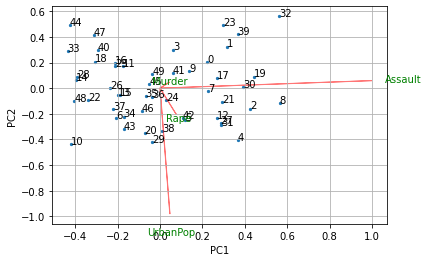

In [12]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

The information on this biplot can also be quantified as follows:

In [13]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

pc1 = abs( pca.components_[0] ) 
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


From the table we can see that Assault has by far the highest importance in the first principle component, while Urban population has the highest importance in the second principle component. These results agree with those deduced from the biplot.

## Standardised data

We standardise the data so that some features are scaled to a size that is more easy to read, while gaining more insight into possible clusters in the data.

In [14]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


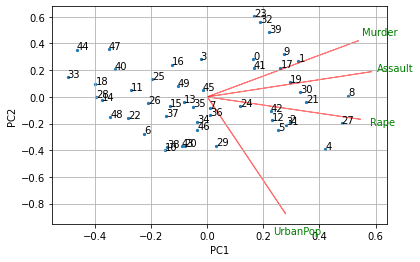

In [15]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

The first principal component seems to have all the data in the positive direction. The second principal component separates the data into 2 directions, which shows the strength of the negative correlations (Rape and Urban Population) and the strength of the positive correlations (Assault and Murder).

The information on this biplot can also be quantified as follows:

In [16]:
# Feature importance

pc1 = abs( std_pca.components_[0] )
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Comparing the new results from this table with the initial table, we can see that the values are more evenly with a few values being lower in importance. 

##  Cumulative variance plot

The first few principal components are the variables that explain most of the variation in the data. Thus a certain number of principal components need to be chosen to explain the variation of the data. By plotting a 'Cumulative variance plot' and 'Scree plot', this number can graphically be obtained.

Text(0.5, 1.0, 'Cumulative Explained Variance')

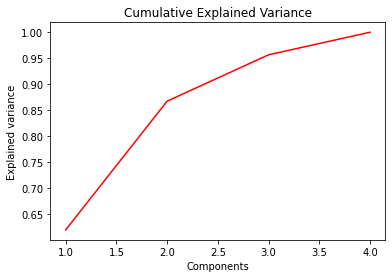

In [17]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

## Scree plot 

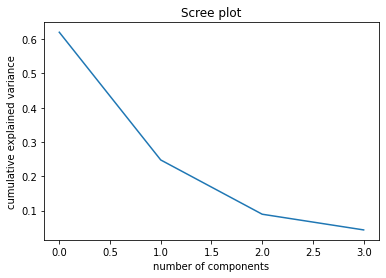

In [18]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 2 principal components together explain around 90% of the variance. We can therefore use them to perform cluster analysis. This is what we refer to as dimensionality reduction. We began with 4 variables and now we have 2 variables explaining most of the variability.

In [19]:
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


# Cluster analysis

We will perform both Hierarchical Clustering and K-means with these data and compare the results.

## Hierarchical clustering

By using Hierarchical clustering we don't need to specify the number of clusters and that we can see it visually in a dendrogram. Only after the algorithm has run, do we need to specify the number of clusters.

To determine the method used to measure the distance between clusters, we plot various dendrograms for the single, complete, and average linkage methods.

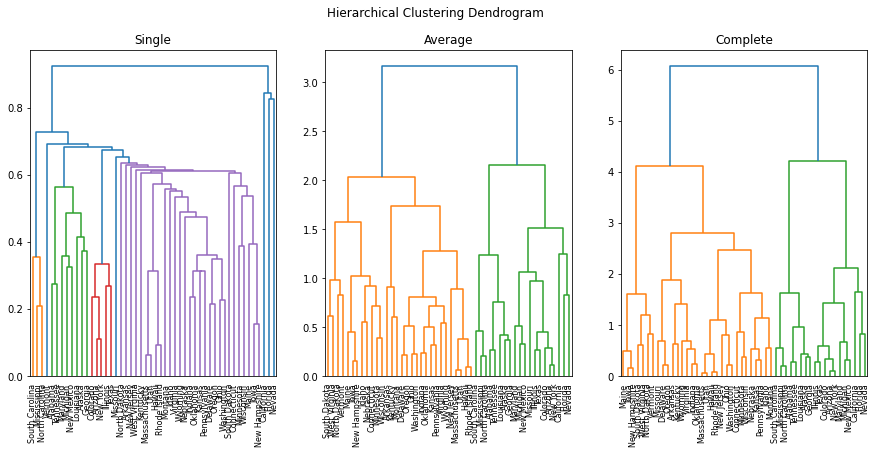

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,6)) 

fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")

dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) 
ax2.set_title("Average")

dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")

dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)

plt.show()

Examining the three dendrograms, the average one seems to be the most balanced dispersion of clusters, and will be our choice. 

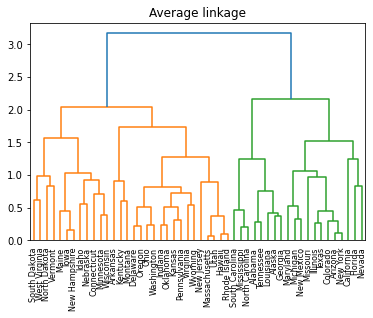

In [21]:
plt.title("Average linkage")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index)
plt.show()

With k = 2, the cluster sizes are as follow:

- Cluster 1 = 30
- Cluster 2 = 20

# K-means clustering

Form the results above, we select K = 2 to plot the k-means cluster graph as shown below.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


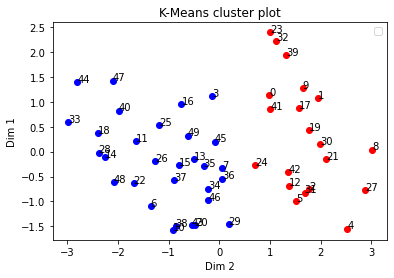

In [22]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=20)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

## Groups - translate to readable names

The city names in each cluster are printed below as shown in groups 1 and 2

In [23]:
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]

group0 = np.array(cities)[group0_indices]
group1 = np.array(cities)[group1_indices]


print("Group 1: {}\n\n".format([data.loc[x]["City"] for x in group0]))
print("Group 2: {}\n\n".format([data.loc[x]["City"] for x in group1]))

Group 1: ['Alabama', 'Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas']


Group 2: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


